### Analytical Question :
#### To acquire a discrete latent representation, we integrate concepts from vector quantization (VQ). Employing the VQ method enables the model to overcome challenges associated with "posterior collapse." This phenomenon, observed in the Variational Autoencoder (VAE) framework, involves the neglect of latent variables when coupled with a potent autoregressive decoder. By incorporating VQ, the model avoids this issue.

#### Furthermore, the discrete latent representations, when combined with an autoregressive prior, empower the model to generate high-quality images, videos, and speech.

In [14]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Download and load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=256, shuffle=False)

In [23]:
import torch
import torch.nn as nn

class codebook(nn.Module):
    def __init__(self, codebook_dim, codebook_size):
        super(codebook, self).__init__()
        self.codebook = nn.Embedding(codebook_size, codebook_dim)
        with torch.no_grad():
            self.codebook.weight.fill_(0.5)

    def forward(self, input_vector):
        distances = torch.norm(input_vector[:, :, None, :] - self.codebook.weight[None, :, :], dim=-1)
        indices = torch.argmin(distances, dim=-1)
        quantized_vector = self.codebook.weight[indices].view(input_vector.shape)
        return quantized_vector

class VQVAE(nn.Module):
    def __init__(self, input_channel, channel_sizes, latent_dim, codebook_size, codebook_dim):
        super(VQVAE, self).__init__()
        self.codebook_dim = codebook_dim
        self.latent_dim = latent_dim
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channel, channel_sizes[0],kernel_size=7, stride=4, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(channel_sizes[0]),
            nn.Conv2d(channel_sizes[0], channel_sizes[1], kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(channel_sizes[1], latent_dim * codebook_dim, kernel_size=3, stride=2, padding=0),
            nn.Sigmoid()
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim * codebook_dim, channel_sizes[1], kernel_size=3, stride=2, padding=0, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(channel_sizes[1], channel_sizes[0], kernel_size=5, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(channel_sizes[0]),
            nn.ReLU(),
            nn.ConvTranspose2d(channel_sizes[0], input_channel, kernel_size=7, stride=4, padding=2, output_padding=1),
            nn.Sigmoid()
        )

        self.codebook = codebook(codebook_dim, codebook_size)

    def forward(self, x):
        x = self.encoder(x)

        if len(x.shape) > 3:
            latent_vector = x.view(x.size(0), self.latent_dim, 1, self.codebook_dim).squeeze(-2)
            quantized_vector = self.codebook(latent_vector)
            x = latent_vector + (self.codebook(latent_vector) - latent_vector).detach()
            x = x.view(x.size(0), self.latent_dim * self.codebook_dim, 1, 1)
        else:
            latent_vector = x.view(1, self.latent_dim, 1, self.codebook_dim)
            quantized_vector = self.codebook(latent_vector)
            x = latent_vector + (quantized_vector - latent_vector).detach()
            x = x.squeeze(0).view(self.latent_dim * self.codebook_dim, 1, 1)

        x = self.decoder(x)

        return x, latent_vector, quantized_vector


Epoch [1/10], Training Loss: 0.175780
Epoch [1/10], Validation Loss: 0.127449


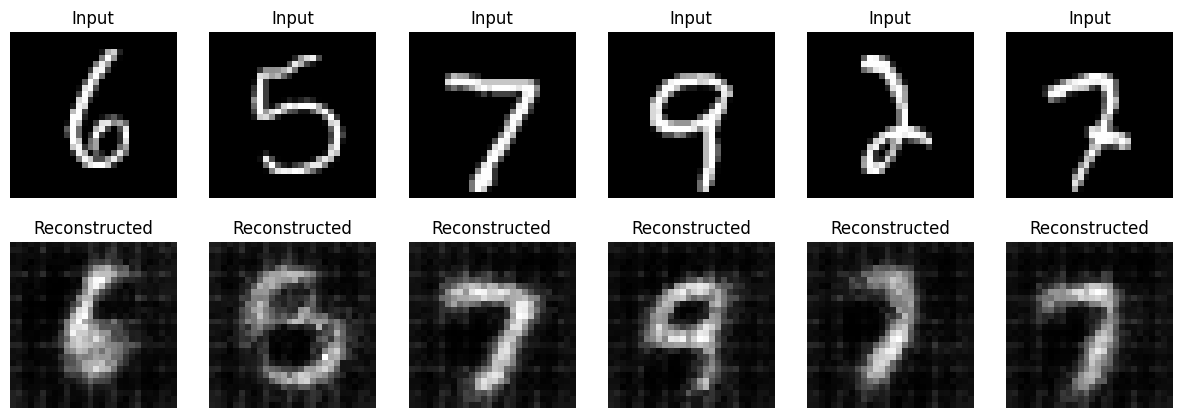

Epoch [2/10], Training Loss: 0.100997
Epoch [2/10], Validation Loss: 0.089247


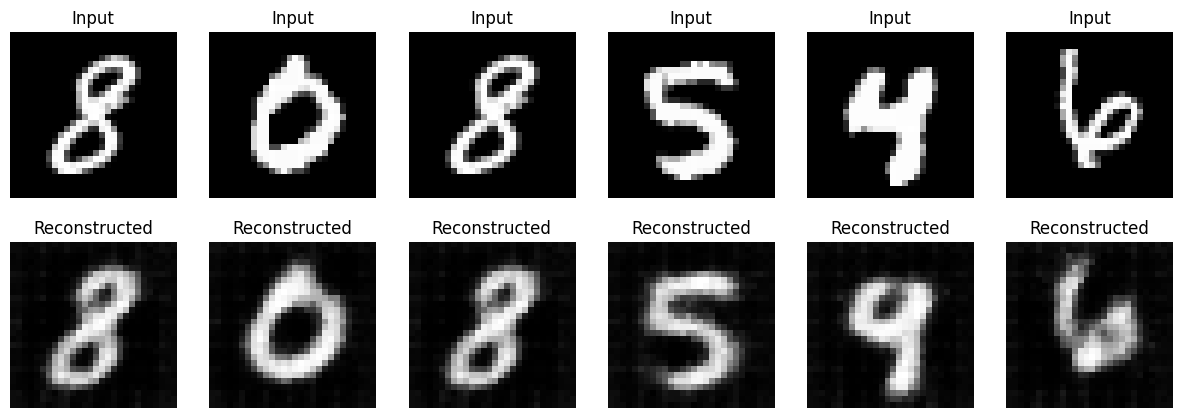

Epoch [3/10], Training Loss: 0.080991
Epoch [3/10], Validation Loss: 0.078526


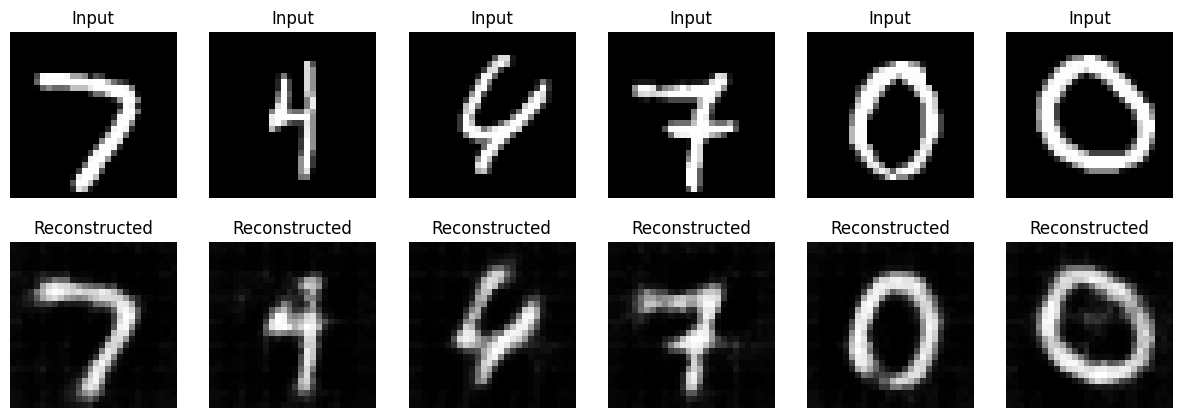

Epoch [4/10], Training Loss: 0.074264
Epoch [4/10], Validation Loss: 0.074705


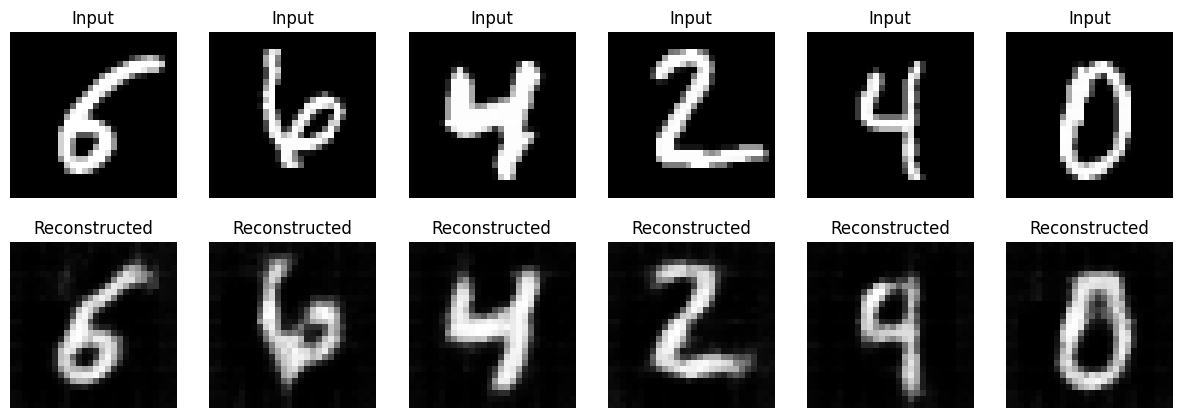

Epoch [5/10], Training Loss: 0.072062
Epoch [5/10], Validation Loss: 0.073498


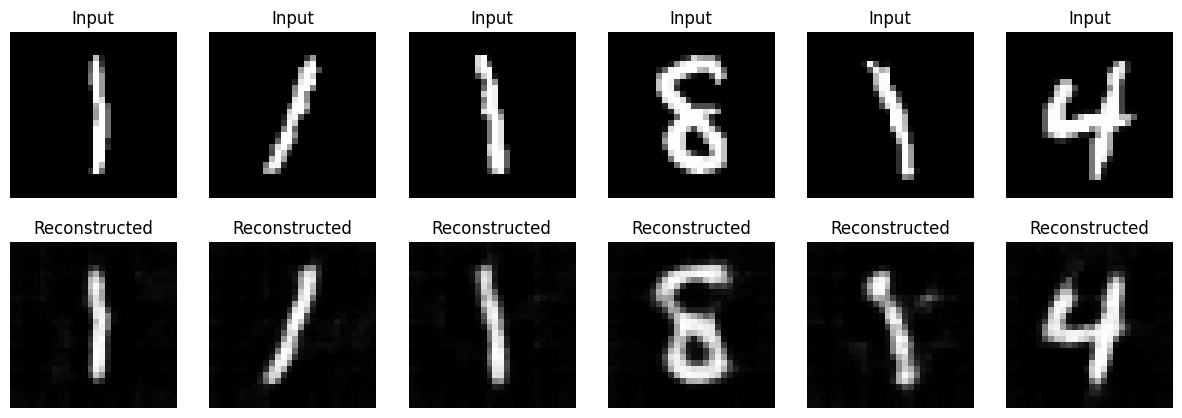

Epoch [6/10], Training Loss: 0.071718
Epoch [6/10], Validation Loss: 0.073751


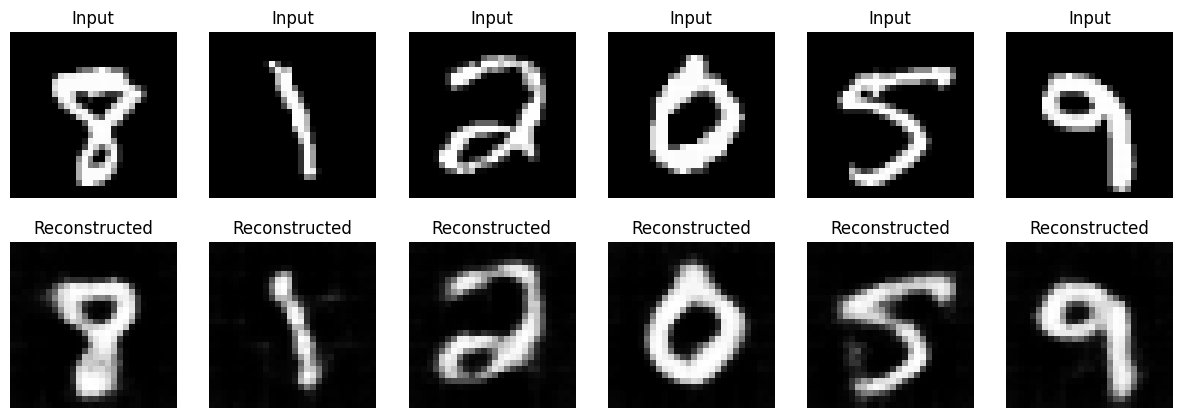

Epoch [7/10], Training Loss: 0.071989
Epoch [7/10], Validation Loss: 0.073998


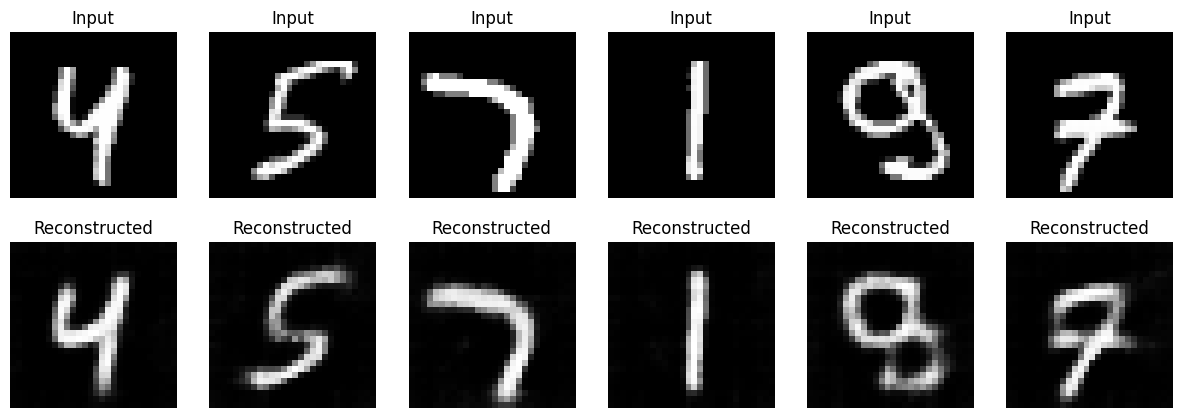

Epoch [8/10], Training Loss: 0.072245
Epoch [8/10], Validation Loss: 0.073965


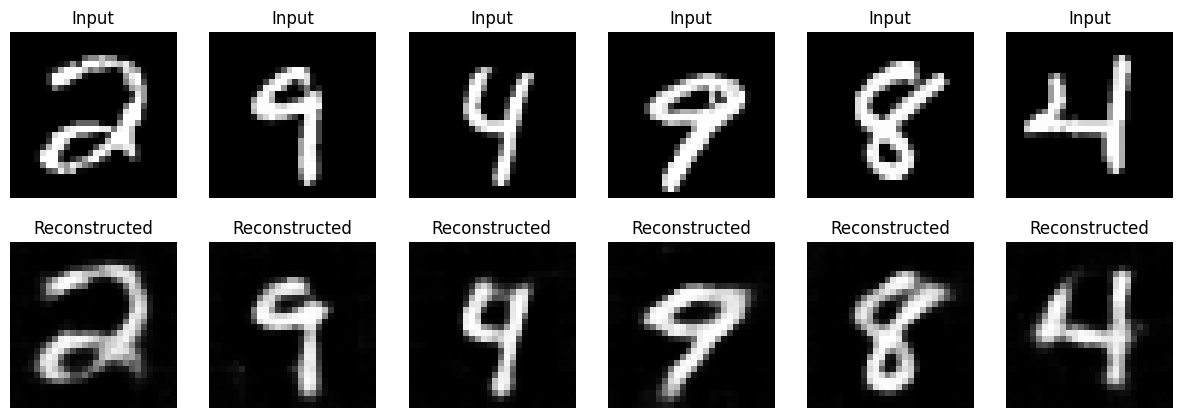

Epoch [9/10], Training Loss: 0.072448
Epoch [9/10], Validation Loss: 0.073903


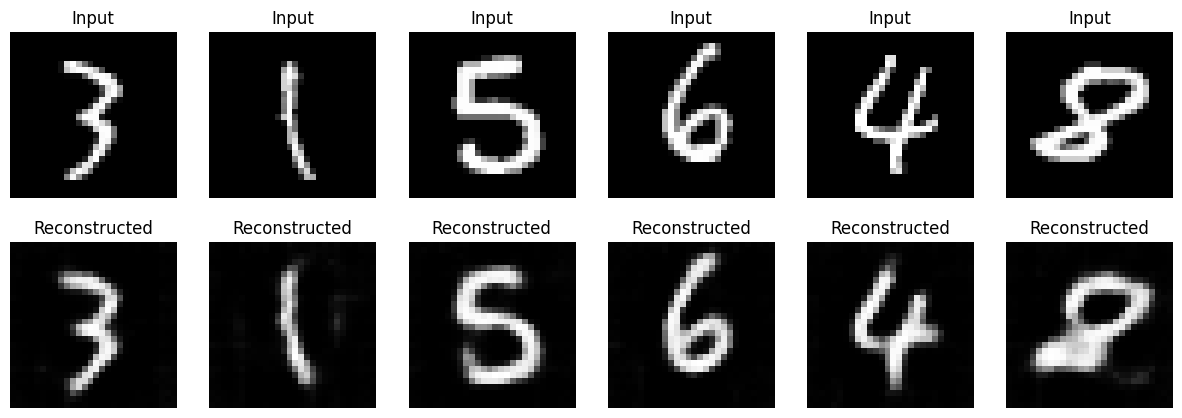

Epoch [10/10], Training Loss: 0.072476
Epoch [10/10], Validation Loss: 0.073882


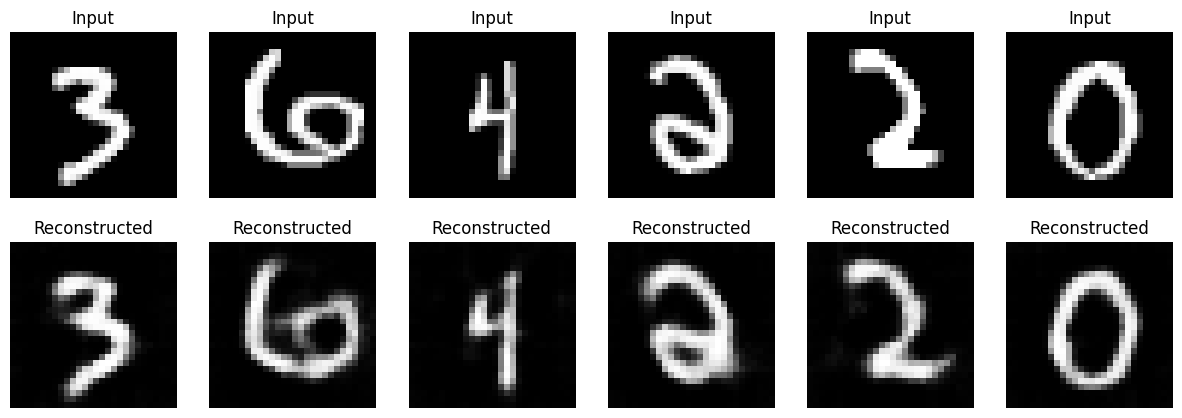

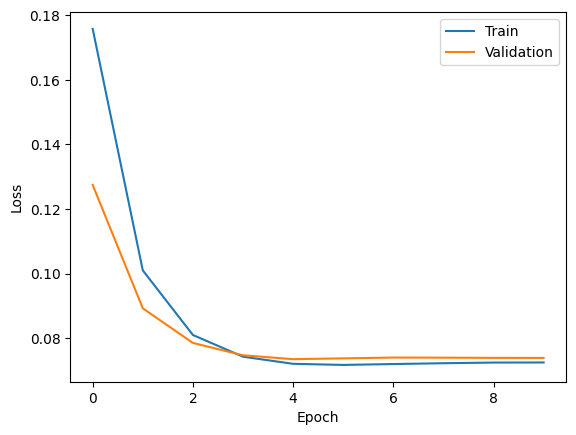

In [34]:
vq_vae = VQVAE(input_channel = 1 , channel_sizes = [64, 64], latent_dim = 64, codebook_size = 3, codebook_dim = 2 ).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vq_vae.parameters(), lr=5e-4)

num_epochs = 10
lambda_co = 0.02
codebooks = []
train_losses = []
valid_losses = []
num_samples = 6


for epoch in range(num_epochs): 
    vq_vae.train()
    running_loss = 0
    for idx, (inputs, _ ) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        recon, latent_vector,quantized_vector  = vq_vae(inputs)
        loss = criterion(recon, inputs) + criterion(latent_vector.detach(), quantized_vector) + lambda_co * criterion(latent_vector, quantized_vector.detach())
        loss.backward()
        optimizer.step()
        codebooks.append(vq_vae.codebook.codebook.weight.detach().cpu())
        running_loss += loss.item()

    # average loss during each epoch
    epoch_loss = running_loss / idx
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.6f}')

    vq_vae.eval()

    with torch.no_grad():
        validation_loss = 0
        for idx, (inputs, _ ) in enumerate(valid_loader):
            inputs = inputs.to(device)
            recon, latent_vector, quantized_vector = vq_vae(inputs)
            loss = criterion(recon, inputs) + criterion(latent_vector.detach(), quantized_vector) + lambda_co * criterion(latent_vector, quantized_vector.detach())
            validation_loss += loss.item()

    validation_epoch_loss = validation_loss / idx
    valid_losses.append(validation_epoch_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {validation_epoch_loss:.6f}')

    with torch.no_grad():
        inputs,_ = next(iter(test_loader))
        inputs = inputs.to(device)

        recons,_,_ = vq_vae(inputs)

        inputs = (inputs + 1) / 2
        recons = (recons + 1) / 2

        plt.figure(figsize=(5*num_samples//2, 5))
        samples = torch.randint(0, inputs.size(0), (num_samples,))
        for i, s in enumerate(samples):
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(inputs[s][0].cpu(), cmap='gray')
            plt.title('Input')
            plt.axis('off')

            plt.subplot(2, num_samples, i + 1 + num_samples)
            plt.imshow(recons[s][0].cpu(), cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')

        plt.show()

# Plot Train & Validation Loss
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

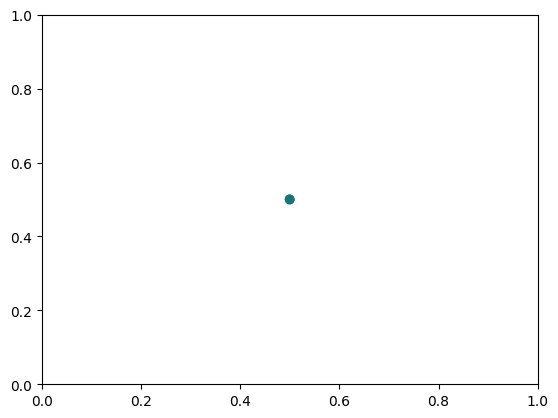

In [35]:
def generate_colors(codebook_size):
    colors1 = torch.linspace(0, 1, codebook_size)
    colors2 = colors1.flip(0)
    colors3 = torch.rand(codebook_size) / 2 + 0.5
    return torch.stack([colors1, colors2, colors3]).view(-1, 3)

def update_plot(frame, cbs, colors, ax):
    ax.clear()
    plt.scatter(cbs[frame * 10, :, 0], cbs[frame * 10, :, 1], c=1 - colors)
    plt.xlim([0, 1])
    plt.ylim([0, 1])



colors = generate_colors(codebook_size = 3)
cbs = torch.stack(codebooks)

fig, ax = plt.subplots()

ani = FuncAnimation(fig, lambda frame: update_plot(frame, cbs, colors, ax),
                    frames=cbs.shape[0] // 10, repeat=False)

ani.save('first.gif', writer='pillow', fps=30)
gif_path = 'first.gif'
html_code = f'<img src="{gif_path}" alt="animation">'
display(HTML(html_code))

Epoch [1/10], Training Loss: 0.081575
Epoch [1/10], Validation Loss: 0.028338


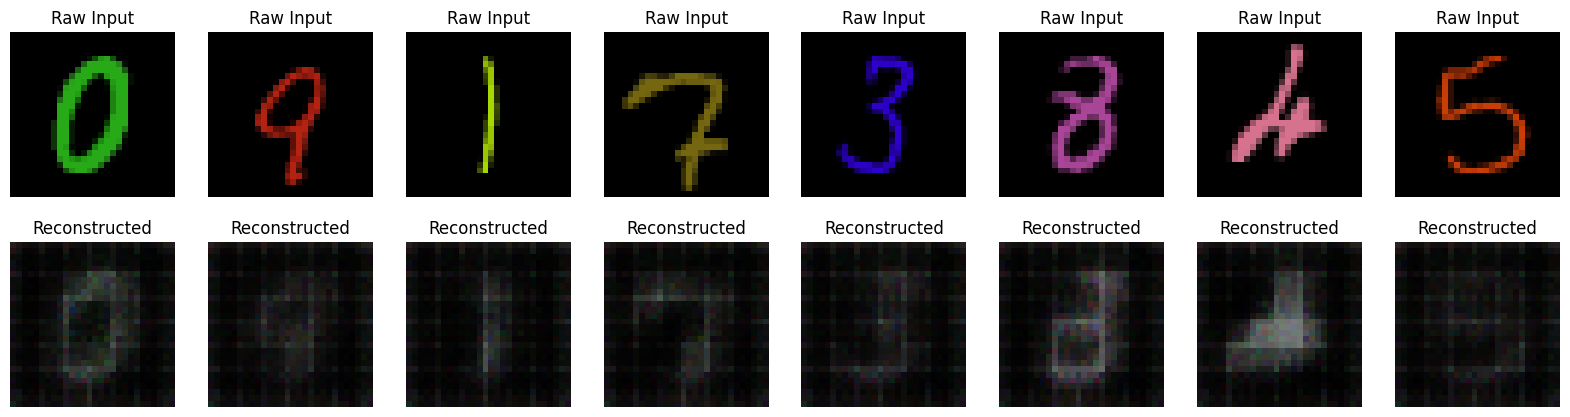

Epoch [2/10], Training Loss: 0.018766
Epoch [2/10], Validation Loss: 0.014175


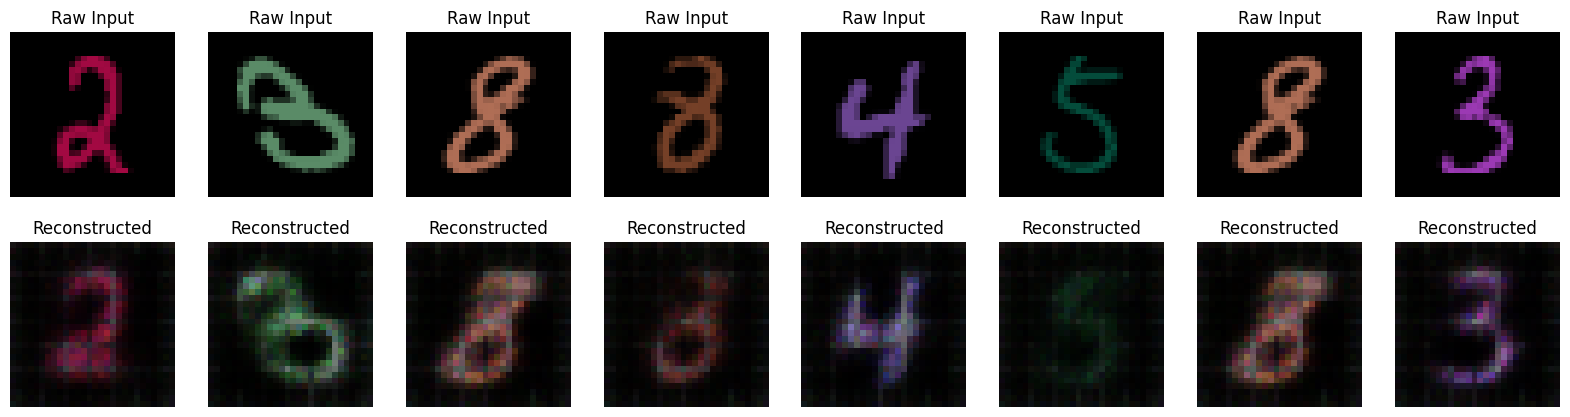

Epoch [3/10], Training Loss: 0.011008
Epoch [3/10], Validation Loss: 0.009087


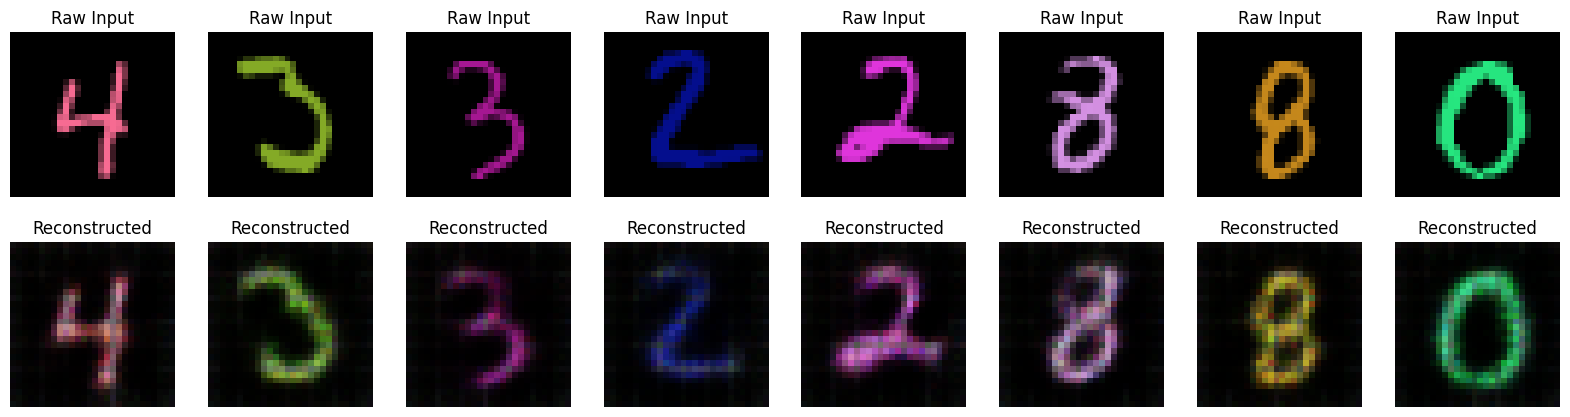

Epoch [4/10], Training Loss: 0.007959
Epoch [4/10], Validation Loss: 0.007424


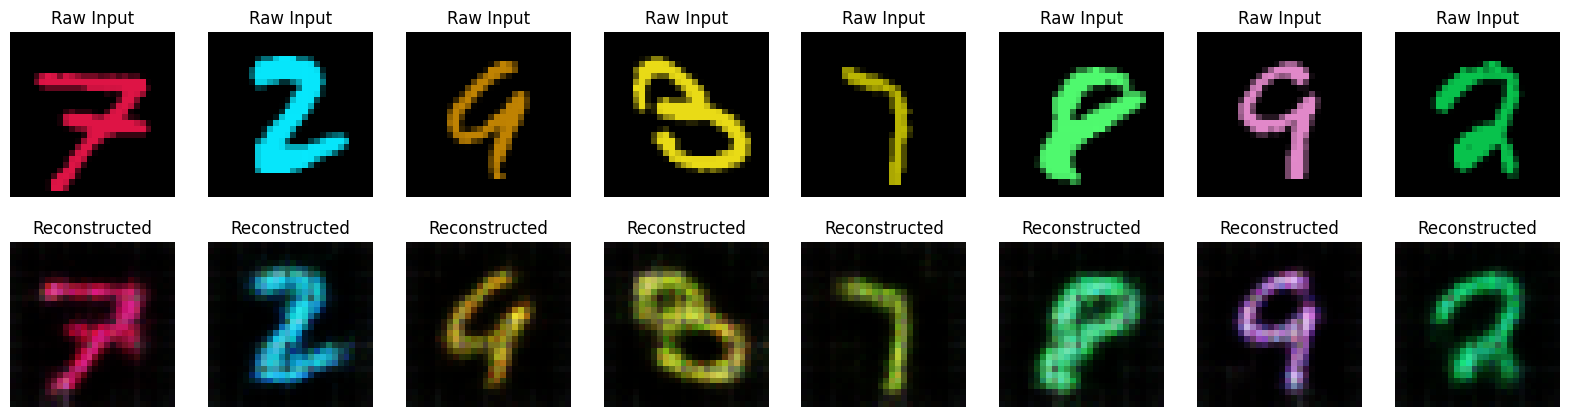

Epoch [5/10], Training Loss: 0.006459
Epoch [5/10], Validation Loss: 0.006061


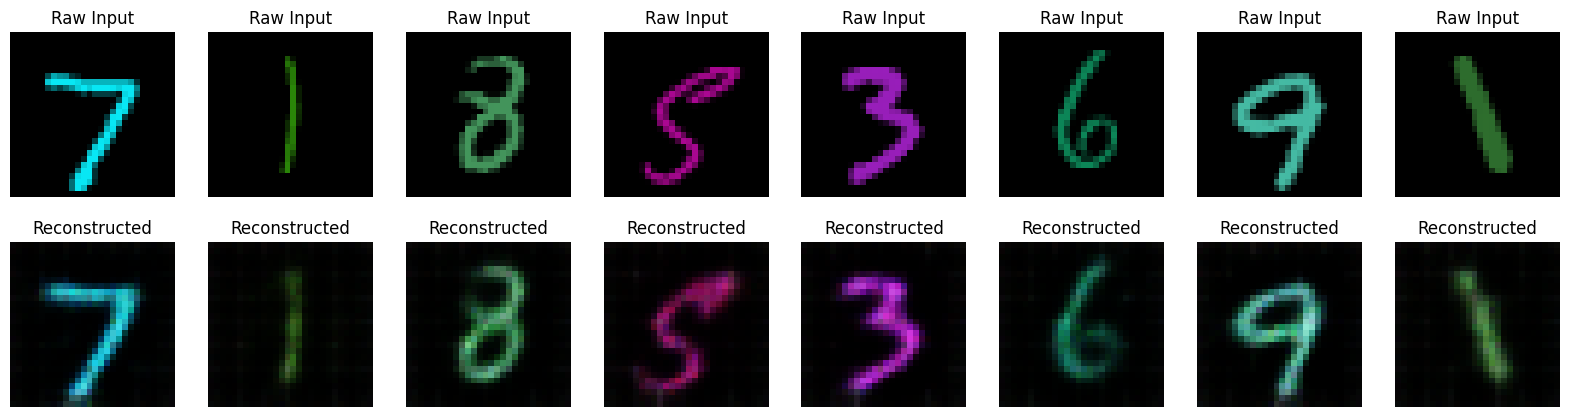

Epoch [6/10], Training Loss: 0.005558
Epoch [6/10], Validation Loss: 0.005320


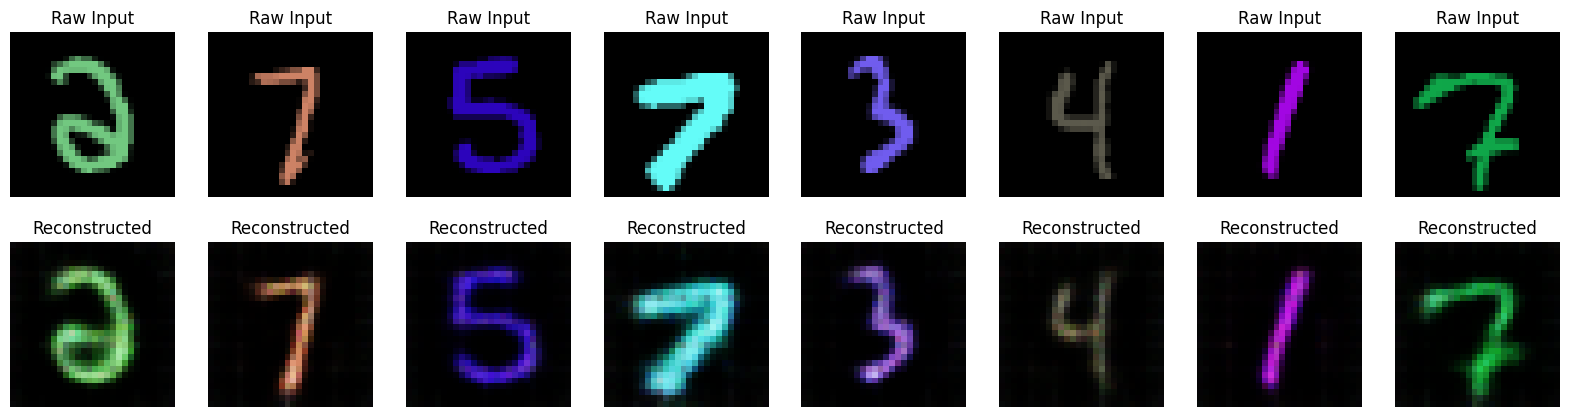

Epoch [7/10], Training Loss: 0.005043
Epoch [7/10], Validation Loss: 0.004870


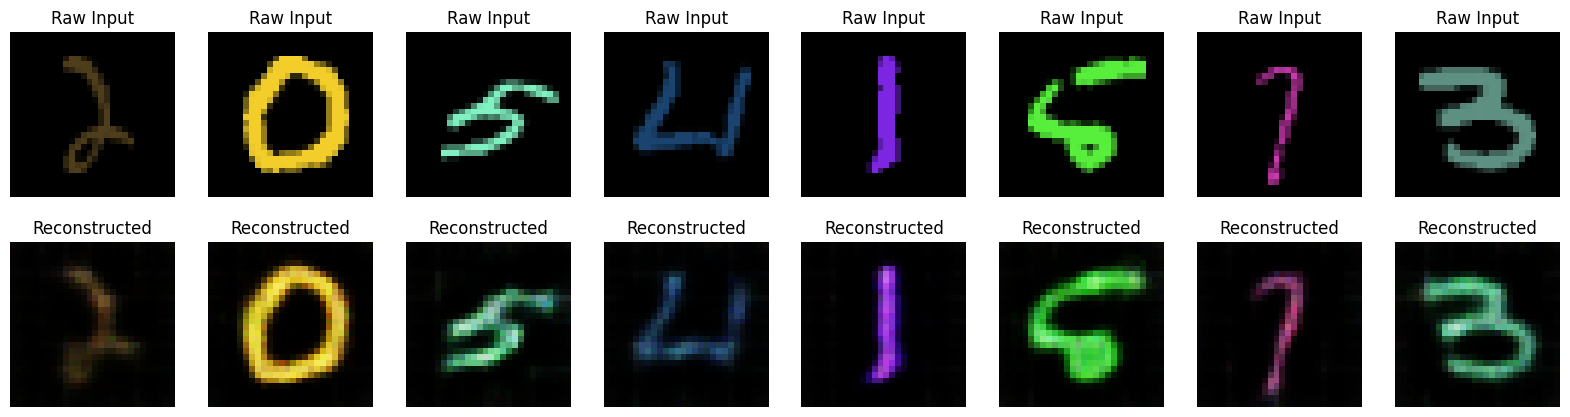

Epoch [8/10], Training Loss: 0.004673
Epoch [8/10], Validation Loss: 0.004643


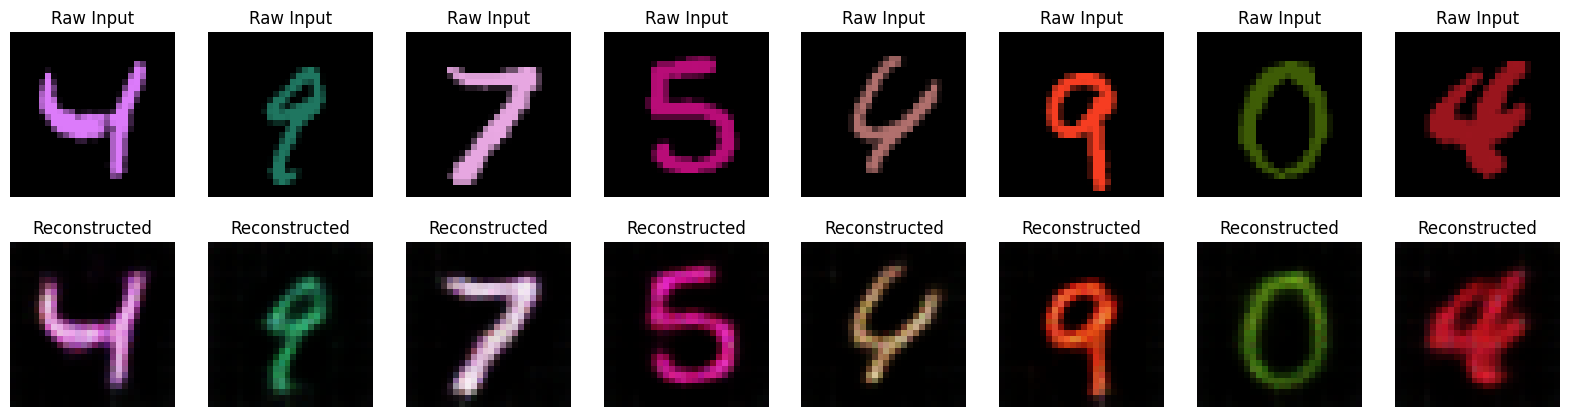

Epoch [9/10], Training Loss: 0.004458
Epoch [9/10], Validation Loss: 0.004490


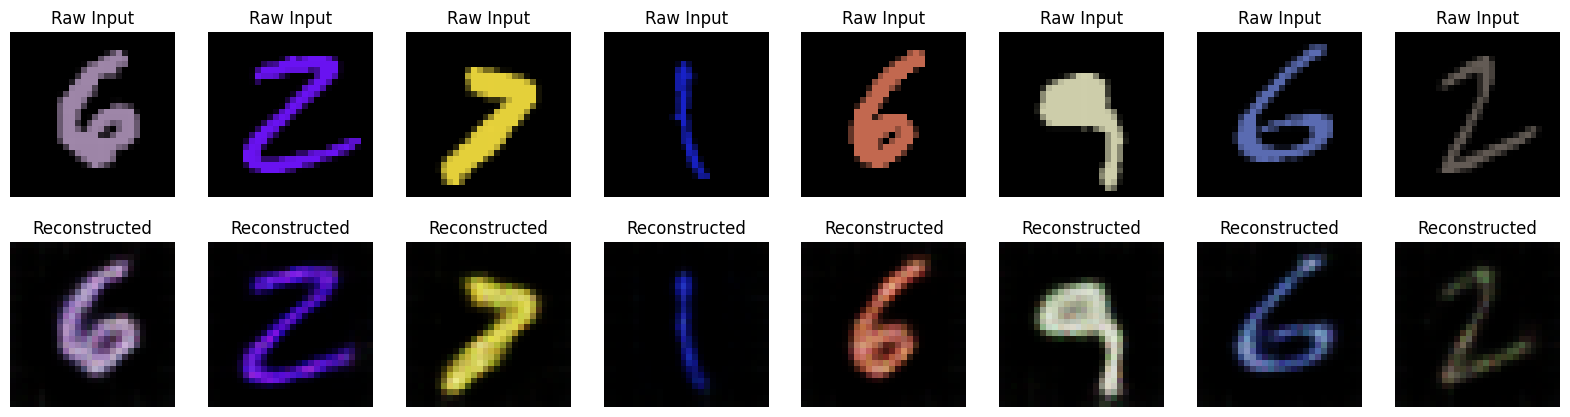

Epoch [10/10], Training Loss: 0.004228
Epoch [10/10], Validation Loss: 0.004400


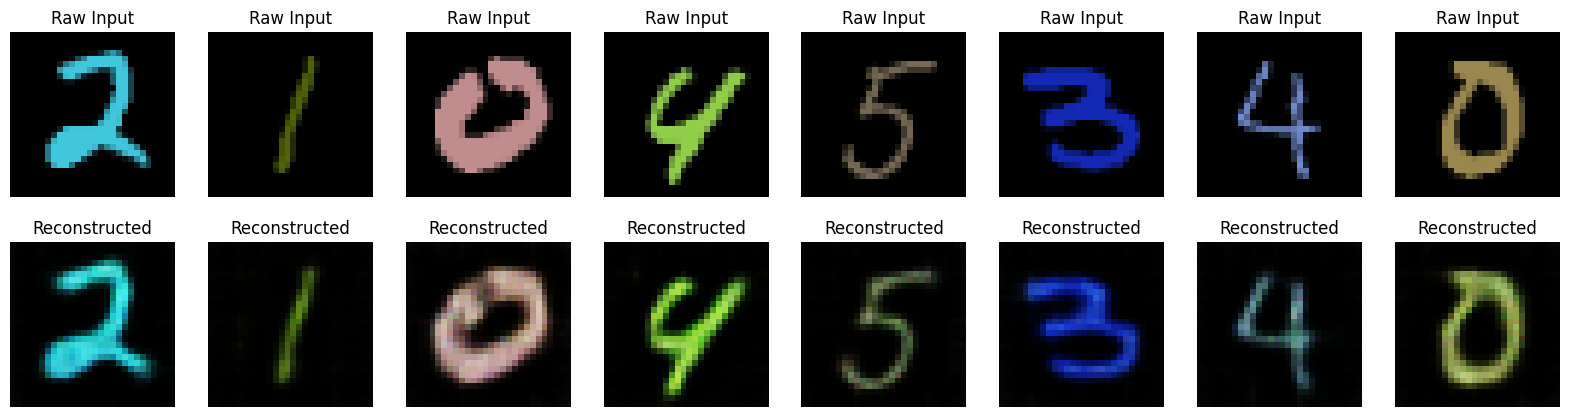

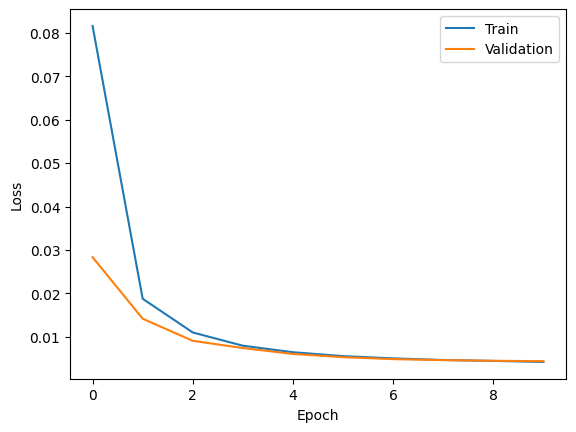

In [42]:
vq_vae = VQVAE(input_channel = 3 , channel_sizes = [64, 64], latent_dim = 64, codebook_size = 50, codebook_dim = 2 ).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vq_vae.parameters(), lr=5e-4)

num_epochs = 10
lambda_co = 0.02
codebooks = []
train_losses = []
valid_losses = []
num_samples = 8


for epoch in range(num_epochs): 
    vq_vae.train()
    running_loss = 0
    for idx, (inputs, _ ) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.repeat(1, 3, 1, 1) * torch.rand(inputs.size(0), 3, 1, 1)
        inputs = inputs.to(device)
        recon, latent_vector,quantized_vector  = vq_vae(inputs)
        loss = criterion(recon, inputs) + criterion(latent_vector.detach(), quantized_vector) + lambda_co * criterion(latent_vector, quantized_vector.detach())
        loss.backward()
        optimizer.step()
        codebooks.append(vq_vae.codebook.codebook.weight.detach().cpu())
        running_loss += loss.item()

    # average loss during each epoch
    epoch_loss = running_loss / idx
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.6f}')

    vq_vae.eval()

    with torch.no_grad():
        validation_loss = 0
        for idx, (inputs, _ ) in enumerate(valid_loader):
            inputs = inputs.repeat(1, 3, 1, 1) * torch.rand(inputs.size(0), 3, 1, 1)
            inputs = inputs.to(device)
            recon, latent_vector, quantized_vector = vq_vae(inputs)
            loss = criterion(recon, inputs) + criterion(latent_vector.detach(), quantized_vector) + lambda_co * criterion(latent_vector, quantized_vector.detach())
            validation_loss += loss.item()

    validation_epoch_loss = validation_loss / idx
    valid_losses.append(validation_epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {validation_epoch_loss:.6f}')
    with torch.no_grad():
        inputs,_ = next(iter(valid_loader))
        inputs = inputs.repeat(1, 3, 1, 1) * torch.rand(inputs.size(0), 3, 1, 1)
        inputs = inputs.to(device)
        recons,_,_ = vq_vae(inputs)
        plt.figure(figsize=(5*num_samples//2, 5))
        samples = torch.randint(0, inputs.size(0), (num_samples,))
        for i, s in enumerate(samples):
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(inputs[s].permute(1, 2, 0).cpu(), cmap='gray')
            plt.title('Raw Input')
            plt.axis('off')

            plt.subplot(2, num_samples, i + 1 + num_samples)
            plt.imshow(recons[s].permute(1, 2, 0).cpu(), cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')

        plt.show()

# Plot Train & Validation Loss
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

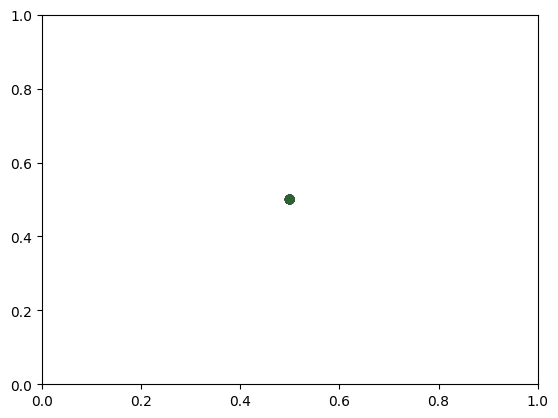

In [43]:
def generate_colors(codebook_size):
    colors1 = torch.linspace(0, 1, codebook_size)
    colors2 = colors1.flip(0)
    colors3 = torch.rand(codebook_size) / 2 + 0.5
    return torch.stack([colors1, colors2, colors3]).view(-1, 3)

def update_plot(frame, cbs, colors, ax):
    ax.clear()
    plt.scatter(cbs[frame * 10, :, 0], cbs[frame * 10, :, 1], c=1 - colors)
    plt.xlim([0, 1])
    plt.ylim([0, 1])



colors = generate_colors(codebook_size = 50)
cbs = torch.stack(codebooks)

fig, ax = plt.subplots()

ani = FuncAnimation(fig, lambda frame: update_plot(frame, cbs, colors, ax),
                    frames=cbs.shape[0] // 10, repeat=False)

ani.save('second.gif', writer='pillow', fps=30)
gif_path = 'second.gif'
html_code = f'<img src="{gif_path}" alt="animation">'
display(HTML(html_code))

Epoch [1/10], Training Loss: 0.127016
Epoch [1/10], Validation Loss: 0.174728


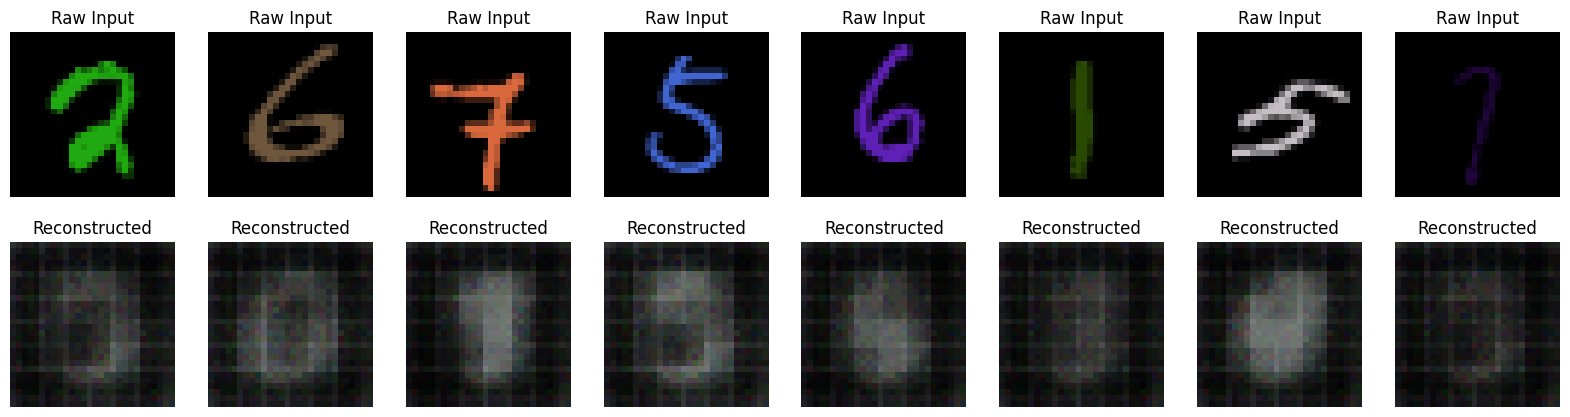

Epoch [2/10], Training Loss: 0.141665
Epoch [2/10], Validation Loss: 0.138352


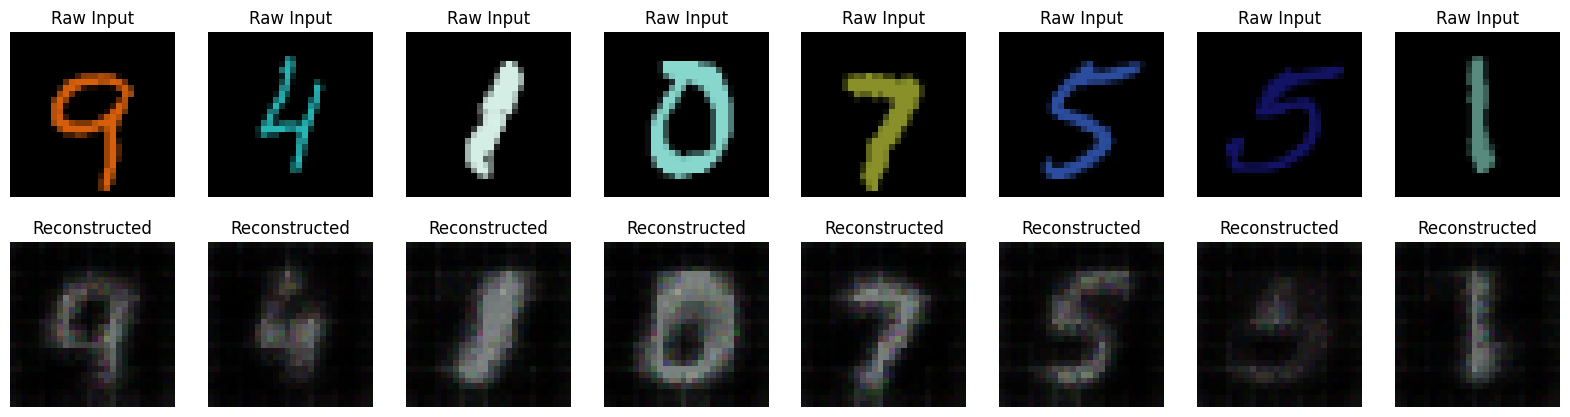

Epoch [3/10], Training Loss: 0.129656
Epoch [3/10], Validation Loss: 0.131491


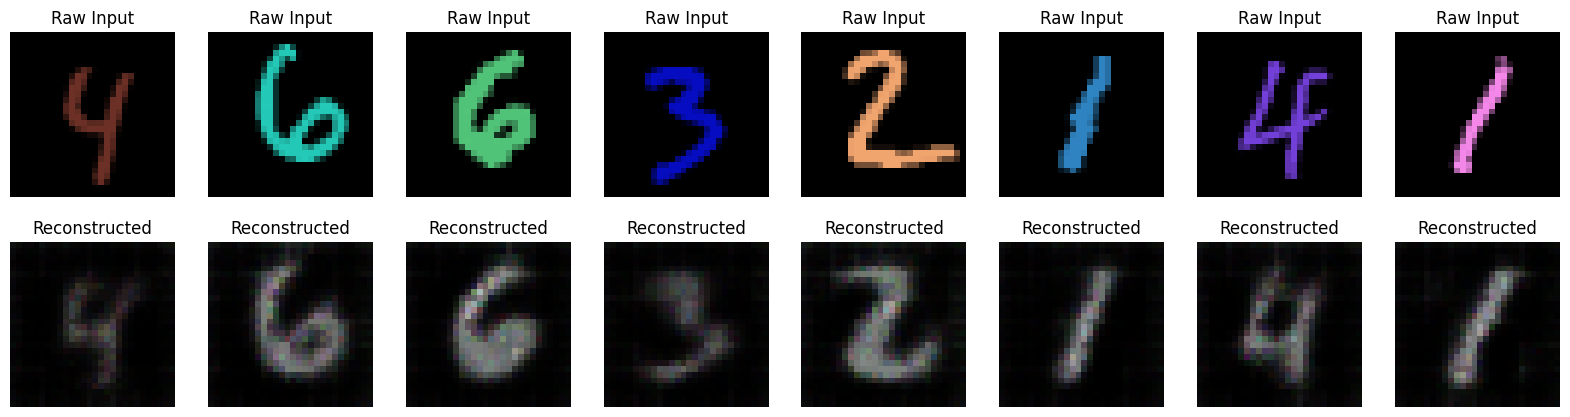

Epoch [4/10], Training Loss: 0.132229
Epoch [4/10], Validation Loss: 0.138458


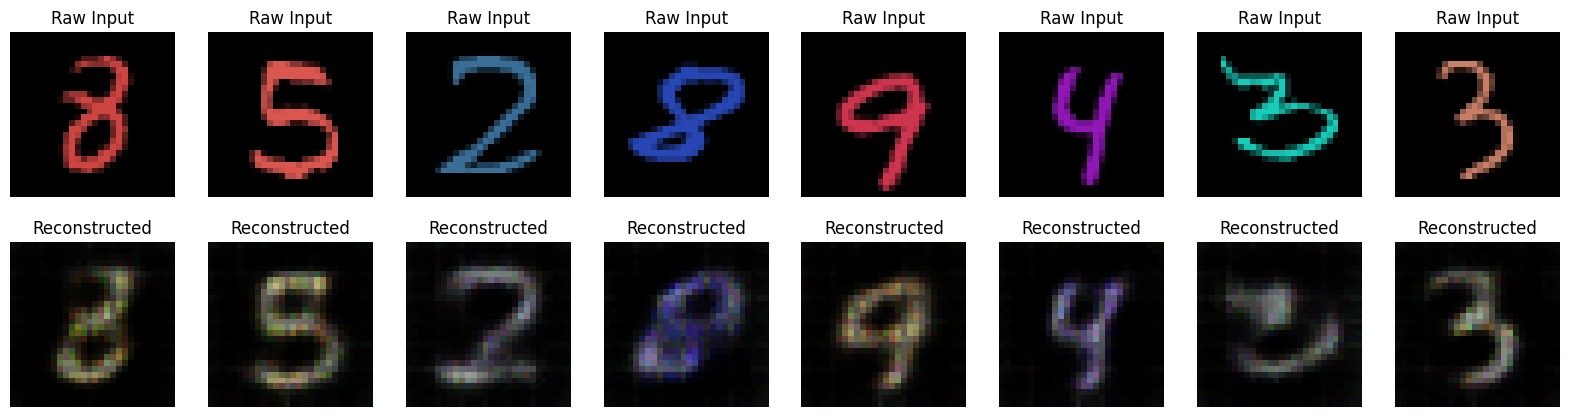

Epoch [5/10], Training Loss: 0.134768
Epoch [5/10], Validation Loss: 0.137745


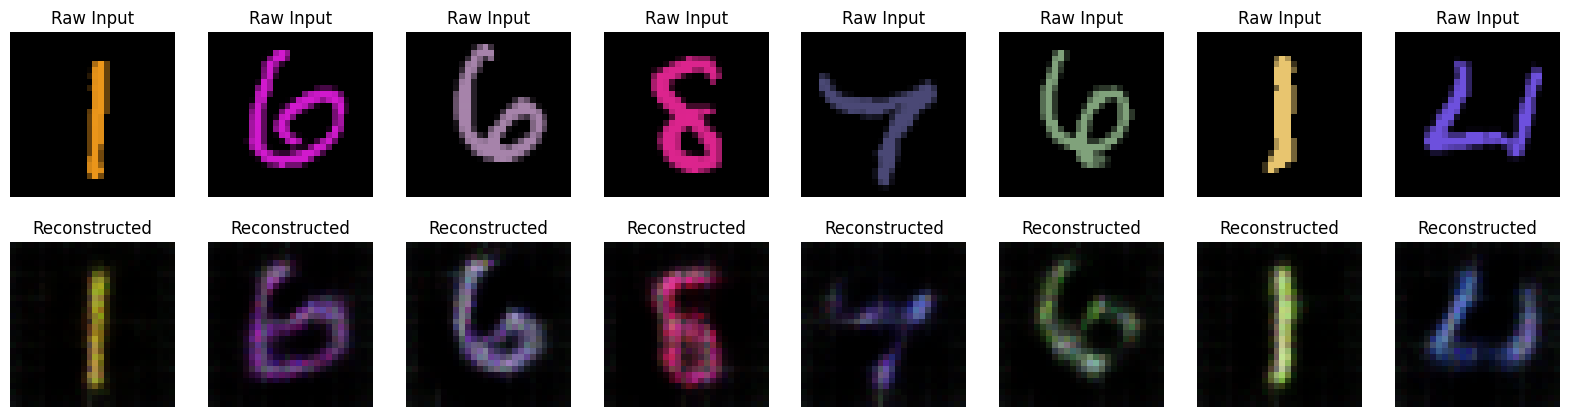

Epoch [6/10], Training Loss: 0.133815
Epoch [6/10], Validation Loss: 0.136478


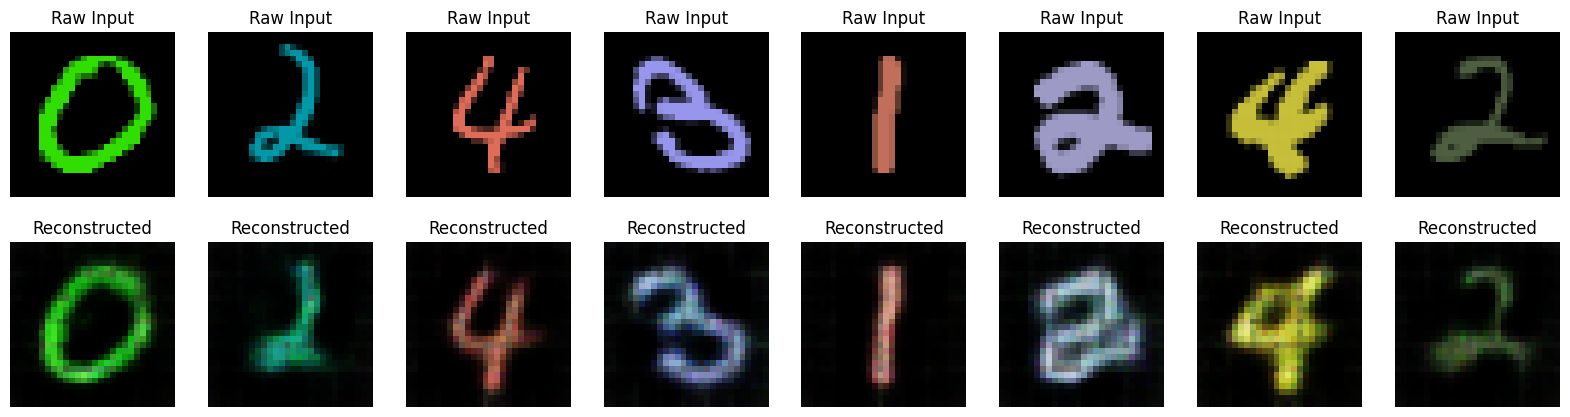

Epoch [7/10], Training Loss: 0.133365
Epoch [7/10], Validation Loss: 0.135875


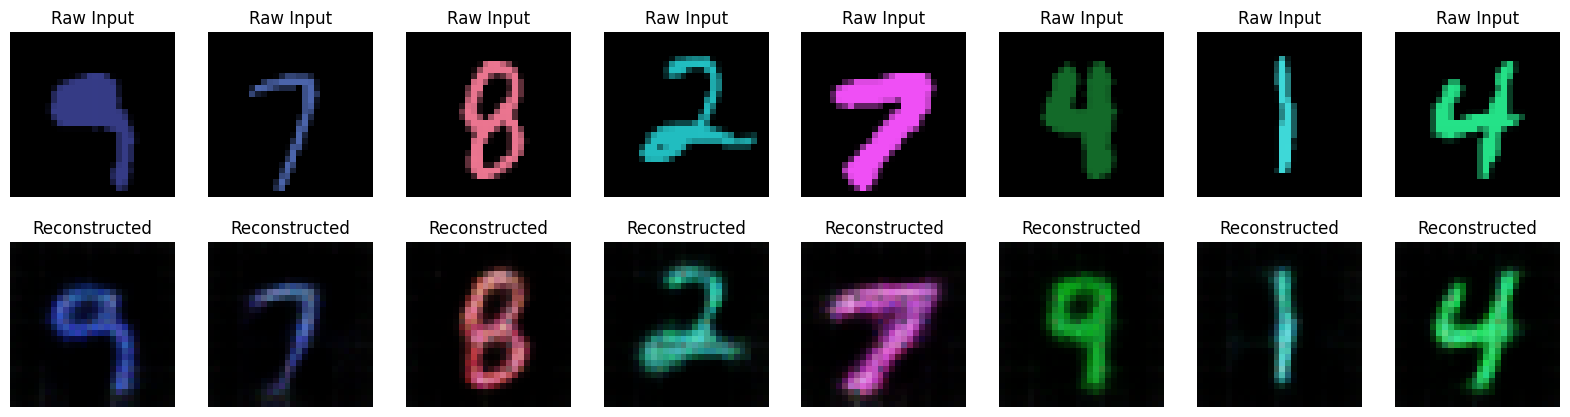

Epoch [8/10], Training Loss: 0.132075
Epoch [8/10], Validation Loss: 0.134897


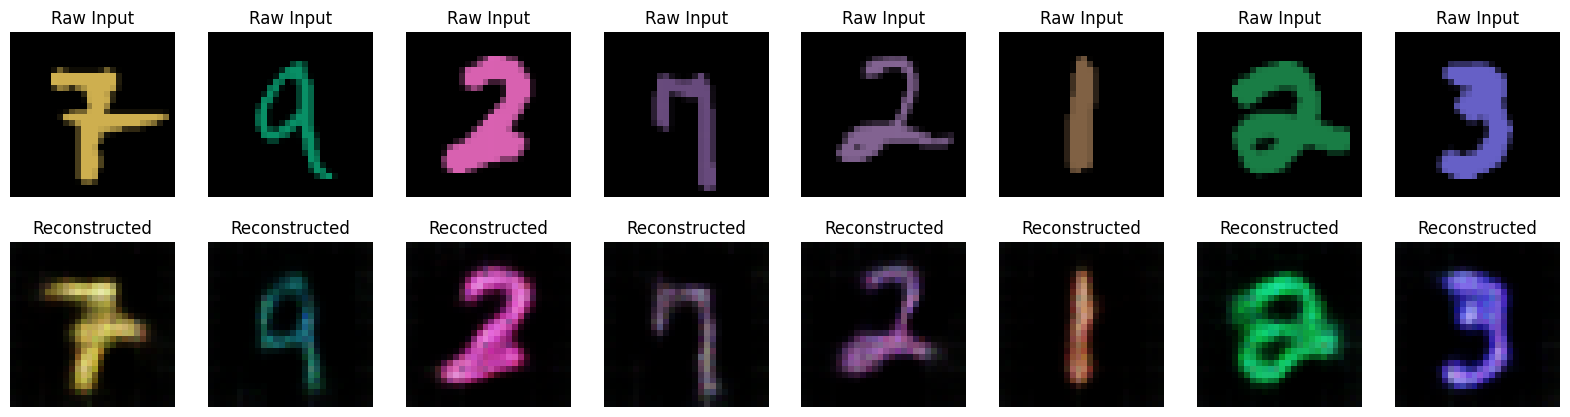

Epoch [9/10], Training Loss: 0.130977
Epoch [9/10], Validation Loss: 0.133015


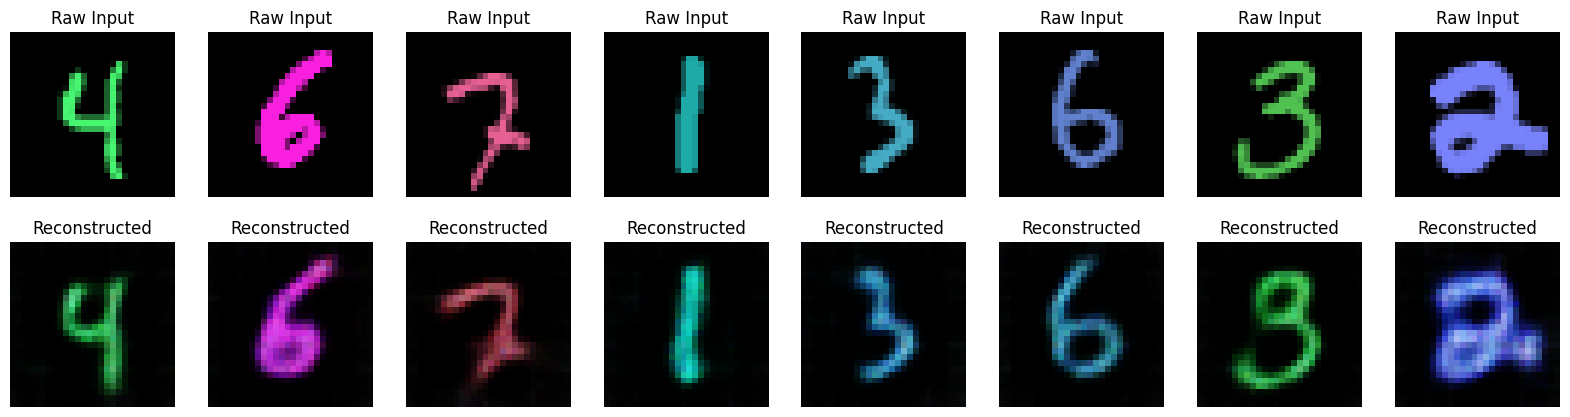

Epoch [10/10], Training Loss: 0.129698
Epoch [10/10], Validation Loss: 0.131311


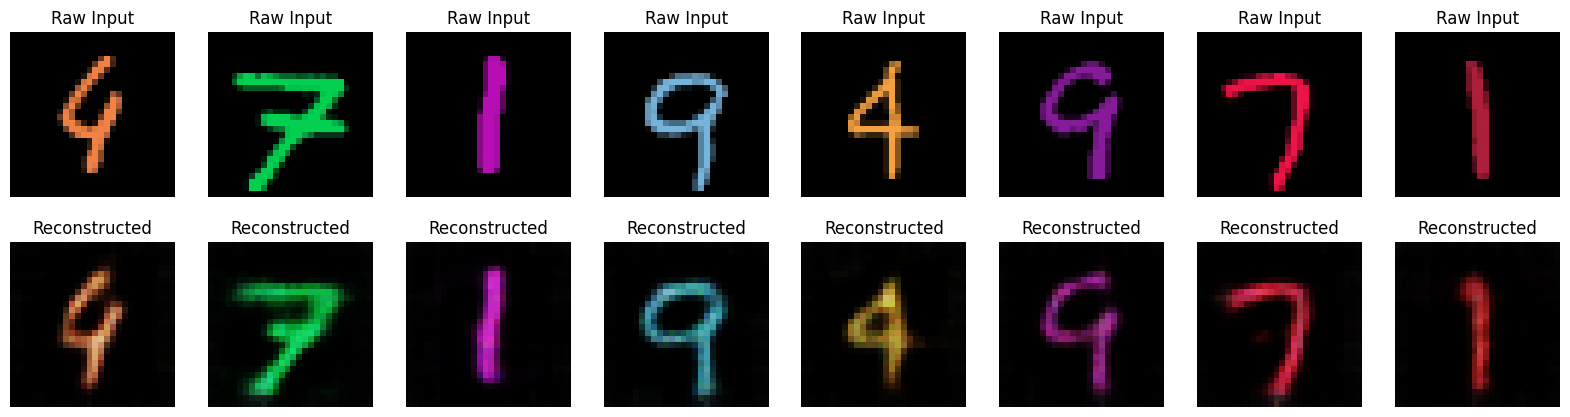

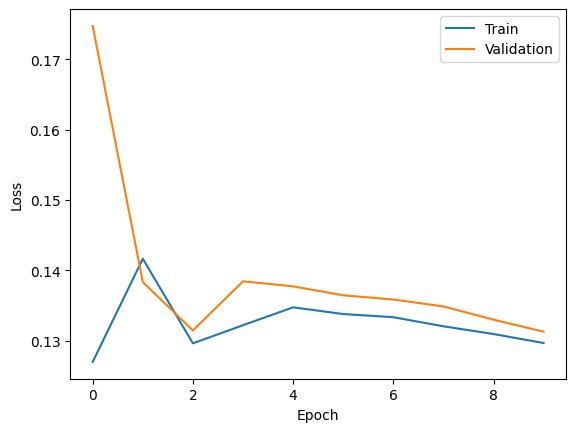

In [44]:
vq_vae = VQVAE(input_channel = 3 , channel_sizes = [64, 64], latent_dim = 64, codebook_size = 3, codebook_dim = 50 ).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vq_vae.parameters(), lr=5e-4)

num_epochs = 10
lambda_co = 0.02
codebooks = []
train_losses = []
valid_losses = []
num_samples = 8


for epoch in range(num_epochs): 
    vq_vae.train()
    running_loss = 0
    for idx, (inputs, _ ) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.repeat(1, 3, 1, 1) * torch.rand(inputs.size(0), 3, 1, 1)
        inputs = inputs.to(device)
        recon, latent_vector,quantized_vector  = vq_vae(inputs)
        loss = criterion(recon, inputs) + criterion(latent_vector.detach(), quantized_vector) + lambda_co * criterion(latent_vector, quantized_vector.detach())
        loss.backward()
        optimizer.step()
        codebooks.append(vq_vae.codebook.codebook.weight.detach().cpu())
        running_loss += loss.item()

    # average loss during each epoch
    epoch_loss = running_loss / idx
    train_losses.append(epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.6f}')

    vq_vae.eval()

    with torch.no_grad():
        validation_loss = 0
        for idx, (inputs, _ ) in enumerate(valid_loader):
            inputs = inputs.repeat(1, 3, 1, 1) * torch.rand(inputs.size(0), 3, 1, 1)
            inputs = inputs.to(device)
            recon, latent_vector, quantized_vector = vq_vae(inputs)
            loss = criterion(recon, inputs) + criterion(latent_vector.detach(), quantized_vector) + lambda_co * criterion(latent_vector, quantized_vector.detach())
            validation_loss += loss.item()

    validation_epoch_loss = validation_loss / idx
    valid_losses.append(validation_epoch_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {validation_epoch_loss:.6f}')
    with torch.no_grad():
        inputs,_ = next(iter(valid_loader))
        inputs = inputs.repeat(1, 3, 1, 1) * torch.rand(inputs.size(0), 3, 1, 1)
        inputs = inputs.to(device)
        recons,_,_ = vq_vae(inputs)
        plt.figure(figsize=(5*num_samples//2, 5))
        samples = torch.randint(0, inputs.size(0), (num_samples,))
        for i, s in enumerate(samples):
            plt.subplot(2, num_samples, i + 1)
            plt.imshow(inputs[s].permute(1, 2, 0).cpu(), cmap='gray')
            plt.title('Raw Input')
            plt.axis('off')

            plt.subplot(2, num_samples, i + 1 + num_samples)
            plt.imshow(recons[s].permute(1, 2, 0).cpu(), cmap='gray')
            plt.title('Reconstructed')
            plt.axis('off')

        plt.show()

# Plot Train & Validation Loss
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

 همانطور که قابل مشاهده است با افزایش سایز کدبوک به مراتب نمونه های تولیدی بهتری میگیریم در مقایسه با زمانی که ابعاد کد بوک را افزایش می دهیم.  
 همچنین  از مجموعه مقادیر تابع هزینه در بخش اموزش و ارزشیابی نیز  قابل استنباط است.